# core

> The plotting functions

In [ ]:
# | default_exp core

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | export
import os
from pathlib import Path
from typing import Tuple, Union

import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import pandas as pd
from matplotlib import pyplot as plt

from goppy import util

In [ ]:
# | hide
if "EXAMPLE_DATA_PATH" not in os.environ.keys():
    os.environ["EXAMPLE_DATA_PATH"] = (
        "/Users/npapadop/Documents/repos/goppy/example_data/"
    )

Before we get started with plotting, we should read in some toy data. This is a modified excerpt
from the _P. litorale_ genome annotation, specifically the part that holds the Hox gene cluster.

In [ ]:
gff = util.read_gff(os.environ["EXAMPLE_DATA_PATH"] + "plit.gff3")
util.decorate(gff, attributes={"gene_id": "ID", "gene_name": "gene"})

hox_genes = [
    "PB.8615",
    "g9718",
    "PB.8616",
    "g9720",
    "g9721",
    "PB.8617",
    "g9723",
    "g9724",
    "g9725",
]
keep = gff["gene_id"].isin(hox_genes)
hox = gff[keep].reset_index(drop=True)

In [ ]:
# | export


def plot_synteny(
    gff,
    block_start: int = None,
    block_end: int = None,
    figsize: (float, float) = None,
    locus_start: str = "start",  # the GFF column with the start position of the gene ("start").
    locus_end: str = "end",  # the GFF column with the end position of the gene ("end").
    molecule: str = "seqid",
    locus_name: str = "gene_name",
    fig_title: str = None,
    save: str | Path = "synteny.svg",
    chromosome_color: str = "lightgray",
    backup_gene_color: str = "darkgray",
    gene_name_offset: float = 0.02,
    chromosome_width: float = 1,
    gene_width: float = 5,
) -> None:
    "Function to plot a syntenic cluster of genes."

    if len(gff[molecule].unique()) > 1:
        raise ValueError(
            f"There are multiple molecules represented in the input GFF: {gff[molecule].unique()}. Please only input a GFF with genes on a single molecule."
        )

    if block_start is None or block_end is None:
        block_start, block_end = util.syntenic_block_borders(gff)

    if figsize is None:
        figsize = util.estimate_plot_size(gff)

    fig, ax = plt.subplots(figsize=figsize)

    # plot contig
    ax.plot(
        [block_start, block_end],
        [0, 0],
        color=chromosome_color,
        linewidth=chromosome_width,
    )
    for name, gene in gff.iterrows():
        start = gene[locus_start]
        end = gene[locus_end]
        if "color" in gene.index:
            color = mcolors.CSS4_COLORS[gene["color"]]
        else:
            color = backup_gene_color

        if "offset" in gene.index:
            offset = gene["offset"]
        else:
            offset = gene_name_offset

        ax.arrow(
            end,
            0,
            start - end - 1000,
            0,
            head_width=0.05,
            head_length=1000,
            fc=color,
            ec=color,
            linewidth=gene_width,
        )
        ax.text(
            gene[locus_start] - 10000,
            offset * 20,
            gene[locus_name],
            color=color,
            fontsize=10,
        )

    ax.set_yticks([])
    ax.set_ylim(-1.5, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    if fig_title is not None:
        ax.set_title(fig_title)
    plt.gca().set_position([0, 0, 1, 1])
    if save is not None:
        if not (isinstance(save, str) | isinstance(save, Path)):
            raise TypeError(
                f"The save location should be a valid Path or string; instead, it is {type(save)}."
            )
        plt.savefig(save, bbox_inches="tight", pad_inches=0)

We can use this function with any GFF dataframe that is reduced to one row per gene (for example a
`type: gene` or `type: mRNA` entry per gene).

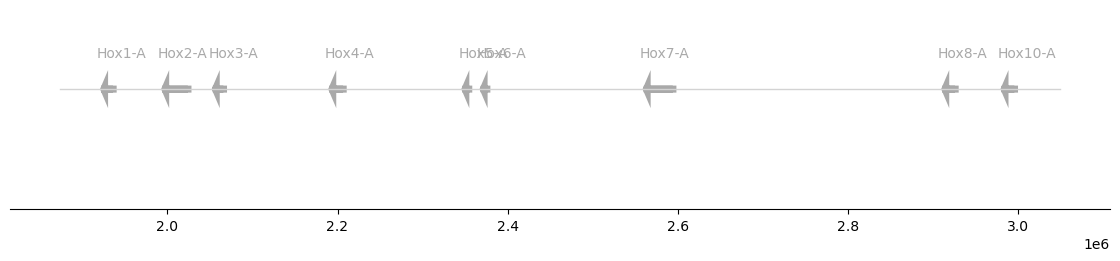

In [ ]:
plot_synteny(hox, figsize=(11, 2))

If the input GFF contains information about the color and the gene name offsets, the plotter will
use them:

In [ ]:
hox["color"] = [
    "red",
    "orange",
    "gold",
    "lightgreen",
    "forestgreen",
    "royalblue",
    "darkblue",
    "darkmagenta",
    "magenta",
]
hox["offset"] = [0.02, -0.025, 0.02, 0.02, 0.02, -0.025, 0.02, 0.02, 0.02]

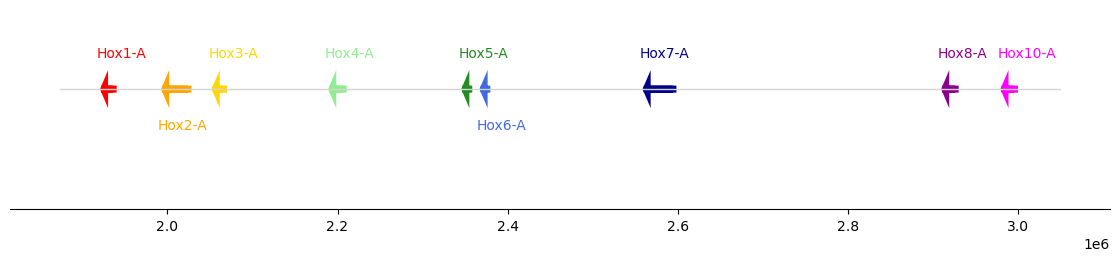

In [ ]:
plot_synteny(hox, figsize=(11, 2))

In [ ]:
# | export


def plot_synteny_schematic(
    gff: pd.DataFrame,  #
    figsize: (float, float) = None,  #
    block_gene: float = 400,  #
    block_dist: float = 200,  #
    locus_start: str = "start",  #
    locus_end: str = "end",  #
    molecule: str = "seqid",  #
    locus_name: str = "gene_name",  #
    save: str | Path = "schematic.svg",  #
    chromosome_color: str = "black",  #
    backup_gene_color: str = "darkgray",  #
    gene_name_offset: float = 0.02,  #
    chromosome_width: float = 3,  #
    head_length: float = 200,  #
    head_width: float = 1.7,  #
    gene_width: float = 1,  #
    return_fig: bool = False,  # whether to return
) -> plt.Figure | plt.Axes | None:
    # 'Function to plot a syntenic cluster of genes.'

    if len(gff[molecule].unique()) > 1:
        raise ValueError(
            f"There are multiple molecules represented in the input GFF: {gff[molecule].unique()}. Please only input a GFF with genes on a single molecule."
        )

    if figsize is None:
        figsize = util.estimate_plot_size(gff)

    fig, ax = plt.subplots(figsize=figsize)

    # the total length is:
    # - the number of gene blocks
    # - the number of gaps between genes (number of gene blocks - 1)
    # - the start and end gap
    total_length = (
        (len(gff) * block_gene) + (2 * block_dist) + ((len(gff) - 1) * block_dist)
    )
    # plot contig
    ax.plot(
        [0, total_length], [0, 0], color=chromosome_color, linewidth=chromosome_width
    )
    start = 0
    end = 0
    for name, gene in gff.sort_values(locus_start).iterrows():
        start = end + block_dist
        end = start + block_gene
        if "color" in gene.index:
            color = mcolors.CSS4_COLORS[gene["color"]]
        else:
            color = backup_gene_color

        if "offset" in gene.index:
            offset = gene["offset"]
        else:
            offset = gene_name_offset

        # Draws an arrow from (x, y) to (x + dx, y + dy). The width of the arrow is scaled by width
        arrow = mpatches.FancyArrow(
            end,
            0,
            start - end + head_length,
            0,
            width=gene_width,
            head_length=head_length,
            head_width=head_width,
            ec="black",
            fc=color,
            lw=chromosome_width,
            zorder=2,
            head_starts_at_zero=False,
        )
        ax.add_patch(arrow)
        # ax.arrow(end, 0, start-end-100, 0, head_width=0.05, head_length=100, fc=color, ec=color, linewidth=gene_width)
        ax.text(
            end - block_gene, offset * 60, gene[locus_name], color="black", fontsize=30
        )

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylim(-1.5, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    plt.gca().set_position([0, 0, 1, 1])
    if save is not None:
        if not (isinstance(save, str) | isinstance(save, Path)):
            raise TypeError(
                f"The save location should be a valid Path or string; instead, it is {type(save)}."
            )
        plt.savefig(save, bbox_inches="tight", pad_inches=0)

    if return_fig:
        return ax

Sometimes (many times) we are not interested in plotting syntenic genes with their real distances;
rather, we are interested in the order and orientation of the genes. This representation can be
achieved with the `plot_synteny_schematic` function, that can process the same sort of input as 
`plot_synteny`.

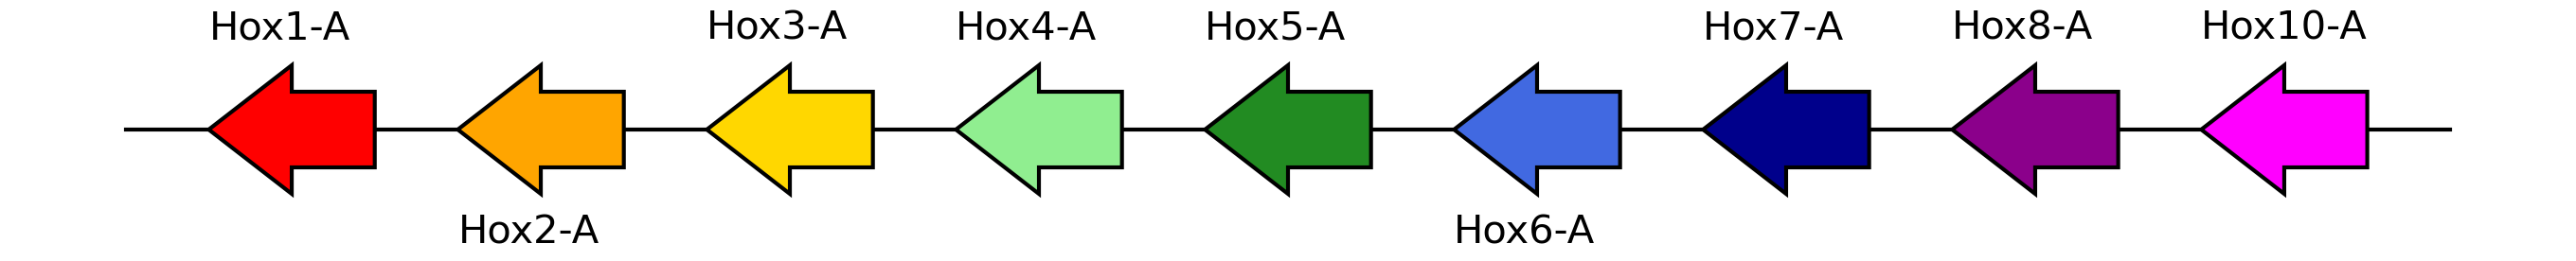

In [ ]:
plot_synteny_schematic(hox)

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()